# Import Data

In [0]:
from statsmodels.tsa.stattools import adfuller

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Import and plot data

                    value  is_anomaly  ...  seasonality2  seasonality3
timestamps                             ...                            
1.416722e+09  -363.278909           0  ...      0.000000      0.000000
1.416726e+09   320.888590           0  ...    115.769759     13.864655
1.416730e+09   891.727422           0  ...    223.650000     27.709919
1.416733e+09  1174.652287           0  ...    316.288863     41.516428
1.416737e+09  1712.290261           0  ...    387.373163     55.264872

[5 rows x 8 columns]
Anomaly shape: (11, 8)


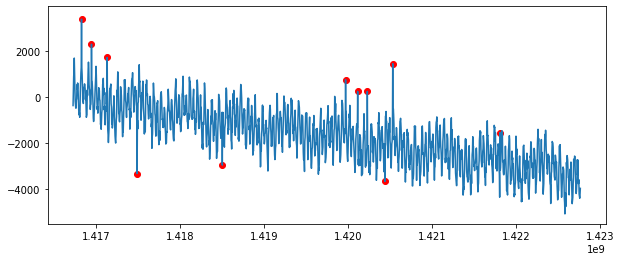

In [0]:
from pandas import read_csv
import matplotlib.pyplot as plt

df = read_csv('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A3Benchmark/A3Benchmark-TS1.csv', header=0, index_col=0, parse_dates=True,squeeze=True)
df.rename(columns={'anomaly':'is_anomaly'}, inplace=True)
df.rename(columns={'asdad':'is_anomaly'}, inplace=True)

print(df.head())
df_anomaly = df.loc[df['is_anomaly']==1.]
print('Anomaly shape:',df_anomaly.shape)
plt.figure(figsize=(10,4))
plt.plot(df.index,df['value'])
plt.scatter(df_anomaly.index, df_anomaly['value'],color='red')
plt.show()

# Box - Jenkins Method:


1.   Identification
2.   Estimation
3.   Diagnostic Checking



## Identification

### Unit Root Testing

#### Orginal Data

In [0]:
from statsmodels.tsa.stattools import adfuller
X = df.iloc[:,0].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))  

ADF Statistic: 3.176938
p-value: 1.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


#### Logged Data

In [0]:
from numpy import log
X = df.iloc[:,0].values
X = log(X)
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.869057
p-value: 0.002275
	1%: -3.435
	5%: -2.864
	10%: -2.568


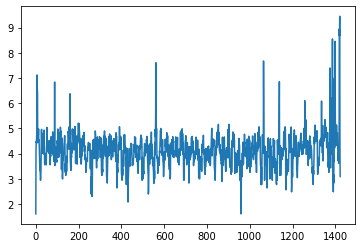

In [0]:
plt.plot(X)

#### Differenced Data

In [0]:
X = df.iloc[:,0].diff().values
X[0] = 0
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -14.011125
p-value: 0.000000
	1%: -3.435
	5%: -2.864
	10%: -2.568


### Scatter Plot Correlation between lags

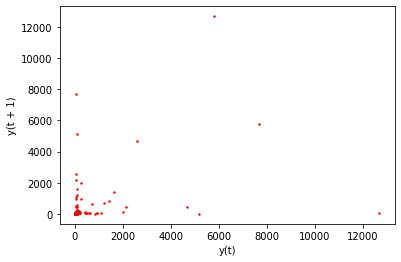

In [0]:
from pandas.plotting import lag_plot
lag_plot(df.iloc[:,0],lag=1,s=2,c='red')


### Correlation between lags

In [0]:
import pandas as pd
values = pd.DataFrame(df.iloc[:,0].values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
result = dataframe.corr()
print(result)

           t      t+1
t    1.00000  0.41531
t+1  0.41531  1.00000


### ACF Plot 

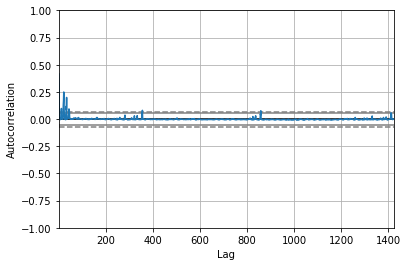

In [0]:
from pandas import read_csv
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
series =pd.DataFrame(df.iloc[:,0].values)
autocorrelation_plot(series)
pyplot.show()

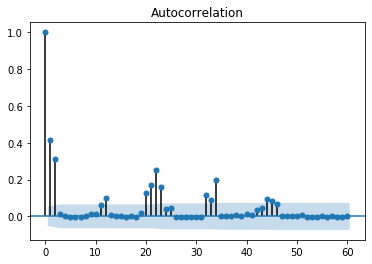

In [0]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
series = pd.DataFrame(df.iloc[:,0].values)
plot_acf(series, lags=60)
pyplot.show()

# Forecasting

## Create Persistent Model

Train shape (1415,)  - Test shape: [   42.    54.    37.  7665.  5781. 12673.    67.]
Test RMSE: 6189.267


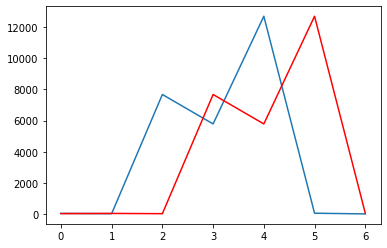

In [0]:
from sklearn.metrics import mean_squared_error
from math import sqrt
series = pd.DataFrame(df.iloc[:,0].values)
# create lagged dataset
values = df.iloc[:,0]
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
# persistence model
def model_persistence(x):
    return x
# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
rmse = sqrt(mean_squared_error(test_y, predictions))
print('Train shape', train_X.shape, ' - Test shape:' , test_X)
print('Test RMSE: %.3f' % rmse)
# plot predictions vs expected
pyplot.plot(test_y)
pyplot.plot(predictions, color='red')
pyplot.show()

## AR Model

In [0]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
import sys

class AR_Compact:

    def model_persistence(self, x):
        return x

    def create_persistence(self):
        predictions = list()
        for x in self.test_X:
            yhat = self.model_persistence(x)
            predictions.append(yhat)
        rmse = sqrt(mean_squared_error(self.test_y, predictions))
        # print('Train shape', self.train_X.shape, ' - Test shape:' , self.test_X.shape)
        print('Persistent Model RMSE: %.3f' % rmse)        


    def __init__(self, path, train_rate):
        self.df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'anomaly':'is_anomaly'}, inplace=True)

        series = pd.DataFrame(self.df.iloc[:,0].values)  
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']

        self.train_size = int(len(self.values) * train_rate)

        self.train, self.test = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        self.train_X, self.train_y = self.train[:,0], self.train[:,1]
        self.test_X, self.test_y = self.test[:,0], self.test[:,1]     
        self.create_persistence()

        # X = (self.dataframe['t+1'] - self.dataframe['t']).values
        X = series.values

        self.train, self.test = X[1:self.train_size], X[self.train_size:]

          
    def fit(self, verbose=False):
        self.model = AR(self.train)
        self.model_fit = self.model.fit()
        self.window = self.model_fit.k_ar
        self.coef = self.model_fit.params  
        if verbose:      
            print('Lag: %s' % self.model_fit.k_ar)
            print('Coefficients: %s' % self.model_fit.params)

    
    def predict(self):
        self.history = self.train[len(self.train)-self.window:]
        self.history = [self.history[i] for i in range(len(self.history))]
        self.predictions = list()
        for t in range(len(self.test)):
            length = len(self.history)
            lag = [self.history[i] for i in range(length-self.window,length)]
            yhat = self.coef[0]
            for d in range(self.window):
                yhat += self.coef[d+1] * lag[self.window-d-1]
            obs = self.test[t]
            self.predictions.append(yhat)
            self.history.append(obs)        
        # for i in range(len(predictions)):
        #     print('predicted=%f, expected=%f' % (predictions[i], test[i]))
        rmse = sqrt(mean_squared_error(self.test, self.predictions))
        self.errors = np.absolute(self.test - np.array(self.predictions))
        print('Prediction Test RMSE: %.3f' % rmse)

    def plot(self):
        # plot predicted error
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        pyplot.figure(figsize=(50,5))
        pyplot.plot(self.test, color='green',  linewidth=0.5,label='True Values')
        pyplot.plot(self.predictions, color='blue',  linewidth=0.5,label='Predictions')
        pyplot.plot(self.errors, color = 'red',  linewidth=0.5, label='Errors')
        pyplot.plot(self.df[self.df['is_anomaly']==1].index[indices] - self.train_size, self.test[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size -1], linestyle="",marker=".", label='Anomalies')
        pyplot.legend()
        pyplot.show()

    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)


### Evaluation

In [0]:
import os
dfs = [pd.DataFrame(columns=['filename', 'auc']), pd.DataFrame(columns=['filename', 'auc']),pd.DataFrame(columns=['filename', 'auc']),pd.DataFrame(columns=['filename', 'auc'])]
files = []
import glob
folders = ['A1Benchmark','A2Benchmark','A3Benchmark','A4Benchmark']
for j,folder in enumerate(folders):
    for i,file in enumerate(glob.glob('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/'+ folder + '/*.csv')):
        print(file,end=' - ')
        ar_model = AR_Compact( file, 0.3)
        ar_model.fit()
        ar_model.predict()
        dfs[j].loc[i] = [os.path.basename(file),ar_model.get_roc_auc(plot=False,verbose=False)]

drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_1.csv - Persistent Model RMSE: 0.078
Prediction Test RMSE: 0.065
AUC:  0.9979879275653925
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_11.csv - Persistent Model RMSE: 7096.367
Prediction Test RMSE: 8104.703
AUC:  0.9763210108604845
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_12.csv - Persistent Model RMSE: 43.267
Prediction Test RMSE: 34.750
AUC:  0.9970238095238095
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_10.csv - Persistent Model RMSE: 0.422
Prediction Test RMSE: 0.428
AUC:  0.9866834554334554
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_13.csv - Persistent Model RMSE: 1163.739
Prediction Test RMSE: 968.687
AUC:  0.8697089947089948
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_15.csv - Persistent Mod

#### Result for UD1 - UD4

In [0]:
print(dfs[0].describe())
print(dfs[1].describe())
print(dfs[2].describe())
print(dfs[3].describe())

             auc
count  59.000000
mean    0.911375
std     0.123055
min     0.382404
25%     0.886264
50%     0.956957
75%     0.988308
max     0.999022
              auc
count  100.000000
mean     0.994767
std      0.004405
min      0.973199
25%      0.990396
50%      0.995980
75%      0.998995
max      0.998995
             auc
count  99.000000
mean    0.994116
std     0.003027
min     0.987129
25%     0.992252
50%     0.994402
75%     0.996599
max     0.999150
             auc
count  98.000000
mean    0.975050
std     0.051572
min     0.701796
25%     0.983806
50%     0.993197
75%     0.996918
max     0.999150


## MA Model


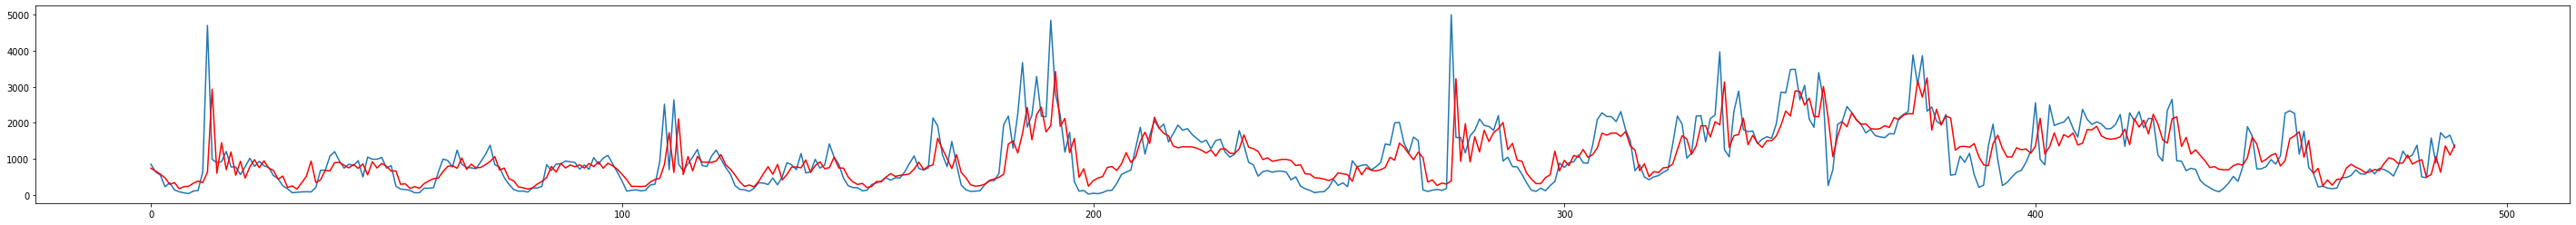

nan

In [0]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot

class MA:
    i = 12345
    def __init__(self, path, train_rate):

        self.df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'anomaly':'is_anomaly'}, inplace=True)
        series = pd.DataFrame(self.df.iloc[:,0].values)  
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']
        X = self.dataframe.values

        self.train_size = int(len(X) * train_rate)    

        train, test = X[1:self.train_size], X[self.train_size:]
        self.train_X, self.train_y = train[:,0], train[:,1]
        self.test_X, self.test_y = test[:,0], test[:,1]        
        # persistence model on training set
        self.train_pred = [x for x in self.train_X]
        # calculate residuals
        self.train_resid = [self.train_y[i]-self.train_pred[i] for i in range(len(self.train_pred))]

    def fit(self, verbose=False):
        self.model = AR(self.train_resid)
        self.model_fit = self.model.fit()
        self.window = self.model_fit.k_ar
        self.coef = self.model_fit.params        
        if verbose:
            print(self.coef)

    def predict(self):
        # walk forward over time steps in test
        self.history = self.train_resid[len(self.train_resid)-self.window:]
        self.history = [self.history[i] for i in range(len(self.history))]
        self.predictions = list()
        for t in range(len(self.test_y)):
            # persistence
            yhat = self.test_X[t]
            error = self.test_y[t] - yhat
            # predict error
            length = len(self.history)
            lag = [self.history[i] for i in range(length-self.window,length)]
            pred_error = self.coef[0]
            for d in range(self.window):
                pred_error += self.coef[d+1] * lag[self.window-d-1]
            # correct the prediction
            yhat = yhat + pred_error
            self.predictions.append(yhat)
            self.history.append(error)
            # print('predicted=%f, expected=%f' % (yhat, test_y[t]))
        rmse = sqrt(mean_squared_error(self.test_y, self.predictions))
        self.errors = np.absolute(self.test_y - np.array(self.predictions))
        # print('Prediction Test RMSE: %.3f' % rmse)

    def plot(self):
        # plot predicted error
        pyplot.figure(figsize=(50,4))
        pyplot.plot(self.test_y)
        pyplot.plot(self.predictions, color='red')
        pyplot.show()       

    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size ]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index - self.train_size ]
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)

ma_model = MA('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_14.csv',0.66)
ma_model.fit()
ma_model.predict()
ma_model.plot()
ma_model.get_roc_auc(verbose=False)

### Evaluation

In [0]:
import os
dfs = [pd.DataFrame(columns=['filename', 'auc']), pd.DataFrame(columns=['filename', 'auc']),pd.DataFrame(columns=['filename', 'auc']),pd.DataFrame(columns=['filename', 'auc'])]
files = []
import glob
folders = ['A1Benchmark','A2Benchmark','A3Benchmark','A4Benchmark']
for j,folder in enumerate(folders):
    for i,file in enumerate(glob.glob('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/'+ folder + '/*.csv')):
        print(file,end=' - ')
        ar_model = MA( file, 0.3)
        ar_model.fit()
        ar_model.predict()
        dfs[j].loc[i] = [os.path.basename(file),ar_model.get_roc_auc(plot=False,verbose=False)]

drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_1.csv - AUC:  0.9979879275653925
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_11.csv - AUC:  0.9766865079365079
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_12.csv - AUC:  0.9975198412698412
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_10.csv - AUC:  0.9382631257631259
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_13.csv - AUC:  0.9516644620811288
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_15.csv - AUC:  0.9327876984126985
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_17.csv - AUC:  0.6745301985250908
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_14.csv - drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benc

#### Result for UD1 - UD4

In [0]:
print(dfs[2].describe())
print(dfs[3].describe())

             auc
count  99.000000
mean    0.994245
std     0.002905
min     0.987245
25%     0.992347
50%     0.994685
75%     0.996599
max     0.999150
             auc
count  98.000000
mean    0.986400
std     0.021606
min     0.878401
25%     0.988946
50%     0.993197
75%     0.996918
max     0.999150


## ARIMA Model

In [0]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
import warnings
import sys

class ARIMA_Compact:

    def model_persistence(self, x):
        return x

    def create_persistence(self):
        predictions = list()
        for x in self.test_X:
            yhat = self.model_persistence(x)
            predictions.append(yhat)
        rmse = sqrt(mean_squared_error(self.test_y, predictions))
        # print('Train shape', self.train_X.shape, ' - Test shape:' , self.test_X.shape)
        # print('Persistent Model RMSE: %.3f' % rmse)        


    def __init__(self, path, train_rate, order):
        
        self.order = order
        self.df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'anomaly':'is_anomaly'}, inplace=True)
        series = pd.DataFrame(self.df.iloc[:,0].values)  
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']
		

        self.train_size = int(len(self.values) * train_rate)

        self.train, self.test = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        self.train_X, self.train_y = self.train[:,0], self.train[:,1]
        self.test_X, self.test_y = self.test[:,0], self.test[:,1]     
        self.create_persistence()

        X = series.values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]
        self.train = self.train.astype('float32')
        self.test = self.test.astype('float32')
          
    def fit(self,  verbose=False):
        self.model = ARIMA(self.train, order = self.order)
        self.model_fit = self.model.fit(disp=0)

    
    def predict(self):
        warnings.filterwarnings("ignore")
        self.history = [x for x in self.train]
        self.predictions = list()
        for t in range(len(self.test)):
            self.model = ARIMA(self.history,order=self.order)
            self.model = self.model.fit(disp=0)
            output = self.model.forecast()
            yhat = output[0]
            self.predictions.append(yhat)
            obs = self.test[t]
            self.history.append(obs)
            sys.stdout.write('\r'+str(t)+':'+str(len(self.test)))
        print('')    
			
        # for i in range(len(predictions)):
        #     print('predicted=%f, expected=%f' % (predictions[i], test[i]))
        rmse = sqrt(mean_squared_error(self.test, self.predictions))
        self.errors = np.absolute(self.test - np.array(self.predictions))
        # print('Prediction Test RMSE: %.3f' % rmse)

    def plot(self):
        # plot predicted error
        pyplot.figure(figsize=(50,5))
        pyplot.plot(self.test_y, color='green',  linewidth=0.5,label='True Values')
        pyplot.plot(self.predictions, color='blue',  linewidth=0.5,label='Predictions')
        pyplot.plot(self.errors, color = 'red',  linewidth=0.5, label='Errors')
        pyplot.legend()
        pyplot.show()


    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size ]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, max(true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended),np.max(self.errors) + np.mean(self.errors))]
        # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)

# arma_model = ARIMA_Compact('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_1.csv', 0.66, (0,0,2))
# arma_model.fit()
# arma_model.predict()
# arma_model.plot()
# arma_model.get_roc_auc(verbose=False)

### Evaluation

7223:7224


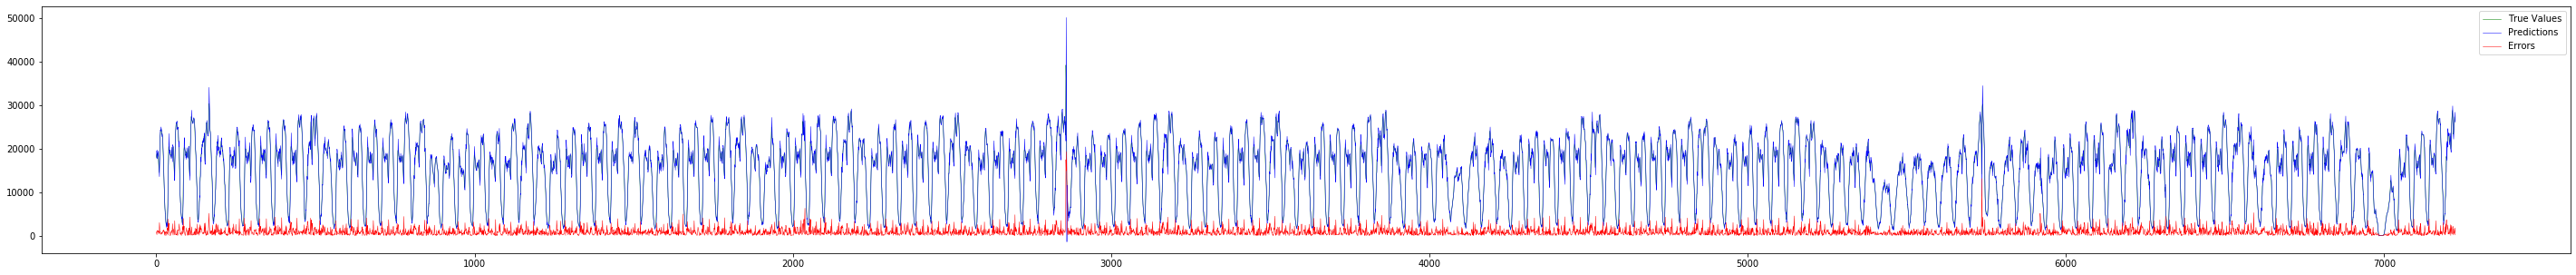

Time:  0:06:03.545362


In [0]:
import os
import datetime
startTime = datetime.datetime.now()
files = []
import glob


ar_model = ARIMA_Compact( 'drive/My Drive/MT/Experiments/Univariate/NYC_Taxi/nyc_taxi.csv', 0.3,(1,1,0))
ar_model.fit()

ar_model.predict()
ar_model.plot()
ar_model.get_roc_auc(plot=False,verbose=False)


endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff)

In [0]:
ar_model.get_roc_auc(plot=False,verbose=False)


0.3462858779609548

#### Results for NYC_Taxi

In [0]:
import os
import datetime
startTime = datetime.datetime.now()
files = []
import glob


ar_model = ARIMA_Compact( 'drive/My Drive/MT/Experiments/Univariate/NYC_Taxi/nyc_taxi.csv', 0.3,(0,2,1))
ar_model.fit()

ar_model.predict()
# ar_model.plot()
ar_model.get_roc_auc(plot=False,verbose=False)


endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff)

7223:7224
AUC:  0.3419889675923024
Time:  0:06:08.994379


In [0]:
import os
import datetime
startTime = datetime.datetime.now()
files = []
import glob


ar_model = ARIMA_Compact( 'drive/My Drive/MT/Experiments/Univariate/NYC_Taxi/nyc_taxi.csv', 0.3,(0,1,3))
ar_model.fit()

ar_model.predict()
# ar_model.plot()
ar_model.get_roc_auc(plot=False,verbose=False)


endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff)

7223:7224
AUC:  0.3483535837912758
Time:  0:24:41.870527


In [0]:
import os
import datetime
startTime = datetime.datetime.now()
files = []
import glob


# ar_model = ARIMA_Compact( 'drive/My Drive/MT/Experiments/Univariate/NYC_Taxi/nyc_taxi.csv', 0.3,(0,1,3))
# ar_model.fit()

ar_model.predict()
# ar_model.plot()
# ar_model.get_roc_auc(plot=False,verbose=False)


endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff)

7223:7224
Time:  0:25:03.559191


## Simple Exponential Smoothing

In [0]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
import warnings
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

class SimpleExponentialSmoothing_Compact:

    def model_persistence(self, x):
        return x

    def create_persistence(self):
        predictions = list()
        for x in self.test_X:
            yhat = self.model_persistence(x)
            predictions.append(yhat)
        rmse = sqrt(mean_squared_error(self.test_y, predictions))
        # print('Train shape', self.train_X.shape, ' - Test shape:' , self.test_X.shape)
        # print('Persistent Model RMSE: %.3f' % rmse)        


    def __init__(self, path, train_rate):
        
        self.df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'anomaly':'is_anomaly'}, inplace=True)
        series = pd.DataFrame(self.df.iloc[:,0].values)  
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']
		

        self.train_size = int(len(self.values) * train_rate)

        self.train, self.test = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        self.train_X, self.train_y = self.train[:,0], self.train[:,1]
        self.test_X, self.test_y = self.test[:,0], self.test[:,1]     
        self.create_persistence()

        X = series.values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]
        self.train = self.train.astype('float32')
        self.test = self.test.astype('float32')

    def fit(self,verbose=False):
        self.fitSimple(verbose)

    def fitSimple(self, verbose=False):
        self.model = SimpleExpSmoothing(self.train)

        self.model = self.model.fit()
        warnings.filterwarnings("ignore")
        self.history = [x for x in self.train]
        self.predictions = list()
        for t in range(len(self.test)):
            self.model = SimpleExpSmoothing(self.history)
            self.model = self.model.fit()
            output = self.model.forecast(1)
            yhat = output
            self.predictions.append(yhat)
            obs = self.test[t]
            self.history.append(obs)
            sys.stdout.write('\r'+str(t)+':'+str(len(self.test)))
        print('')    
			
        # for i in range(len(predictions)):
        #     print('predicted=%f, expected=%f' % (predictions[i], test[i]))
        rmse = sqrt(mean_squared_error(self.test, self.predictions))
        self.errors = np.absolute(self.test - np.array(self.predictions))
        # print('Prediction Test RMSE: %.3f' % rmse)


    def plot(self):
        # plot predicted error
        pyplot.figure(figsize=(50,5))
        pyplot.plot(self.test)
        pyplot.plot(self.predictions, color='red')
        pyplot.plot(self.errors, color = 'yellow')
        pyplot.plot(self.df[self.df['is_anomaly']==1].index[indices] - self.train_size, self.test[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size -1], linestyle="",marker=".", label='Anomalies')
        pyplot.show()

    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size ]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan

        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)


# arma_model = SimpleExponentialSmoothing_Compact('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_1.csv', 0.66)

# arma_model.fit()
# arma_model.plot()
# arma_model.get_roc_auc(verbose=False)

### Evaluation

#### Results for UD1-UD4

In [0]:
print(dfs[0].describe())
print(dfs[1].describe())
print(dfs[2].describe())
print(dfs[3].describe())

             auc
count  59.000000
mean    0.824894
std     0.249851
min     0.058706
25%     0.769434
50%     0.936376
75%     0.979900
max     0.999022
              auc
count  100.000000
mean     0.932215
std      0.118326
min      0.424456
25%      0.933166
50%      0.995038
75%      0.998995
max      0.998995
             auc
count  99.000000
mean    0.990782
std     0.007064
min     0.942942
25%     0.988261
50%     0.991922
75%     0.995004
max     0.999150
             auc
count  98.000000
mean    0.969333
std     0.047000
min     0.759495
25%     0.970344
50%     0.988261
75%     0.995403
max     0.999150


## Exponential Smoothing

In [0]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
import warnings
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

class ExponentialSmoothing_Compact:

    def model_persistence(self, x):
        return x

    def create_persistence(self):
        predictions = list()
        for x in self.test_X:
            yhat = self.model_persistence(x)
            predictions.append(yhat)
        rmse = sqrt(mean_squared_error(self.test_y, predictions))
        # print('Train shape', self.train_X.shape, ' - Test shape:' , self.test_X.shape)
        # print('Persistent Model RMSE: %.3f' % rmse)        


    def __init__(self, path, train_rate):
        
        self.df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
        series = pd.DataFrame(self.df.iloc[:,0].values)  
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'anomaly':'is_anomaly'}, inplace=True)
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']
		

        self.train_size = int(len(self.values) * train_rate)

        self.train, self.test = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        self.train_X, self.train_y = self.train[:,0], self.train[:,1]
        self.test_X, self.test_y = self.test[:,0], self.test[:,1]     
        self.create_persistence()

        X = series.values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]
        self.train = self.train.astype('float32')
        self.test = self.test.astype('float32')


    def fit(self,  trendvalue,verbose=False):
        self.model = ExponentialSmoothing(self.train, trend=trendvalue)

        self.model = self.model.fit()
        warnings.filterwarnings("ignore")
        self.history = [x for x in self.train]
        self.predictions = list()
        for t in range(len(self.test)):
            self.model = ExponentialSmoothing(self.history, trend=trendvalue)
            self.model = self.model.fit()
            output = self.model.forecast(1)
            yhat = output
            self.predictions.append(yhat)
            obs = self.test[t]
            self.history.append(obs)
            sys.stdout.write('\r'+str(t)+':'+str(len(self.test)))
        print('')    
			
        # for i in range(len(predictions)):
        #     print('predicted=%f, expected=%f' % (predictions[i], test[i]))
        rmse = sqrt(mean_squared_error(self.test, self.predictions))
        self.errors = np.absolute(self.test - np.array(self.predictions))
        # print('Prediction Test RMSE: %.3f' % rmse)


    def plot(self):
        # plot predicted error
        pyplot.figure(figsize=(50,5))
        pyplot.plot(self.test)
        pyplot.plot(self.predictions, color='red')
        pyplot.plot(self.errors, color = 'yellow')
        pyplot.show()

    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size ]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)

# arma_model = ExponentialSmoothing_Compact('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_1.csv', 0.66)
# arma_model.fit(trendvalue='add')
# arma_model.plot()
# arma_model.get_roc_auc(verbose=False)


### Evaluation

#### Results for UD1-UD4

In [0]:
print(dfs[0].describe())
print(dfs[1].describe())
print(dfs[2].describe())
print(dfs[3].describe())

             auc
count  59.000000
mean    0.830289
std     0.243405
min     0.067753
25%     0.763651
50%     0.932370
75%     0.978578
max     0.999022
              auc
count  100.000000
mean     0.957964
std      0.072906
min      0.719151
25%      0.971985
50%      0.994975
75%      0.998995
max      0.998995
             auc
count  99.000000
mean    0.989360
std     0.007060
min     0.942900
25%     0.985332
50%     0.990221
75%     0.993463
max     0.998724
             auc
count  98.000000
mean    0.971991
std     0.040264
min     0.826159
25%     0.971068
50%     0.988399
75%     0.995004
max     0.999150


## PCI

In [0]:
import numpy as np
import statistics
import math
import matplotlib.pyplot as plt
import scipy.stats
import ipywidgets as widgets
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from pandas import read_csv
from tqdm import tqdm_notebook, tnrange



class PCI:

    def __init__(self, path, train_rate, window_width=50):
        self.df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
        series = self.df.iloc[:,0]
        self.window_width = window_width
        # split into train and test sets

        self.X = series.values
        size = int(len(self.X ) * train_rate)

        self.train_size = int(len(series.values) * train_rate)
        self.train, self.test = self.X[0:size], self.X[size:len(self.X)]

    def getWindow_Mean(self, sqlResult, row_index, column_index, window_width):
        '''
        sqlResult: The data from mysql database starting with the timestamp field
        row_index: The record we want to analyze if it contains anomalies
        column_index: the field in the sqlresult we want to analyze for the currenct record
        window_width: the amount of data we bundle to compute mean and std 
        This function gets all the data that are window_width * 0.5 before and after the current data point and 
        then it computes the std and mean of it. Then it looks if they are more than 3*std away from the mean
        '''
        lst_field = []
        lst_timestamp = []
        for counter,x in enumerate(sqlResult):
            lst_field.append(x)
            lst_timestamp.append(counter)

        index_begin = max(0,int(row_index-window_width/2))
        index_end = min(len(lst_field),int(row_index+window_width/2))-1
        sliced_lst_field = lst_field[index_begin:index_end]
        sliced_lst_timestamp = lst_timestamp[index_begin:index_end]
        mean=statistics.mean(sliced_lst_field)
        std = statistics.stdev(sliced_lst_field)
        lst_ad_field = []
        lst_ad_timestamp = []
        lst_ad_timestamp_range = []
        for counter,elem in enumerate(sliced_lst_field):
            if abs(elem - mean) > 3*(std):
                lst_ad_field.append(elem)
                lst_ad_timestamp.append(sliced_lst_timestamp[counter])
                lst_ad_timestamp_range.append((lst_timestamp[index_begin],lst_timestamp[index_end-1]))
        return lst_ad_timestamp,lst_ad_field, set(lst_ad_timestamp_range)

    def getWindowedAnomalies(self, sql_result,show_range=False):
        '''
        sqlResult: The data from mysql database starting with the timestamp field
        window_width: the amount of data we bundle to compute mean and std 
        show_range: If anomlay is detected for a data point, it marks the range of data that has been analyzed gray
        This functions iterates over the whole data in sql_result and detects anomalies that have a value more than 3*std away from mean
        it only analyzed this data for the second field in sql_result. The first field must contain the timestamp
        '''
        glb_lst_ad_timestamp, glb_lst_ad_field, glb_lst_ad_range_begin, glb_lst_ad_range_end = [],[], [],[]
        lst_timestamp = []
        lst_field = []
        sliced_sqlResult = []
        for counter, row in tqdm_notebook(enumerate(sql_result), total=len(sql_result)):
            lst_timestamp.append(counter)
            lst_field.append(row)

            lst_ad_timestamp, lst_ad_field, lst_ad_range = self.getWindow_Mean(sql_result,counter,1,self.window_width)
            glb_lst_ad_timestamp += lst_ad_timestamp
            glb_lst_ad_field += lst_ad_field
            if show_range:
                for ad_range in lst_ad_range:
                    glb_lst_ad_range_begin.append(ad_range[0])
                    glb_lst_ad_range_end.append(ad_range[1])

        plt.figure(figsize=(18,5))
        plt.plot(lst_timestamp, lst_field)

        for counter,_ in enumerate(glb_lst_ad_range_begin):
            plt.axvspan(glb_lst_ad_range_begin[counter], glb_lst_ad_range_end[counter], color='gray', alpha=0.1)

        plt.plot(glb_lst_ad_timestamp, glb_lst_ad_field, linestyle="",marker=".")
        plt.show()

    def calculatePCI(self, sql_result,index, k, BothSidedWindow= True):
        '''
        sqlResult: The data from mysql database starting with the timestamp field
        index: The record we want to analyze if it contains anomalies
        k: the k parameter from the paper
        BothSideWindow: if true we look left and right of the datapoint, otherwise just left of the datapoint 
        This function implements completely the algorith proposed in the mentioned paper. Instead of using Students t-Test
        I implemented a similar approach using Z-table of normal distribution
        '''
        lst_values = []
        start = 0
        end = 0
        if BothSidedWindow:
            start =max(0,index-k)
            end = min(len(sql_result), index+k)-1
        else:
            start = max(0,index - 2*k)
            end = min(len(sql_result),index)
        v_i_zaehler = 0
        v_i_nenner = 0
        for counter,i in enumerate(range(start,end )):
            if i == index:
                continue
            lst_values.append(sql_result[i])
            w = 0
            if i<index:
                w = counter+1
            else:
                w = 2*k - counter 
            v_i_zaehler += sql_result[i]*w
            v_i_nenner +=w
        # if we cannot predict, just return the value
        if v_i_zaehler == 0 or len(lst_values)<2: 
            return (sql_result[index]-1,sql_result[index]+1)
        
        v_index = v_i_zaehler/v_i_nenner
        std = statistics.stdev(lst_values)

        t_student=0
        # the higher k the closer z to 0.5 - max = 120
        # 0.5 + ((120-min(k,120))/120)*0.4999999999
        percentile = 0.5 + ((120-min(k,120))/120)*0.4999999999
        z = scipy.stats.norm.ppf(percentile)
        delta = z * std* np.sqrt(1+1/2*k)
        PCI = (v_index - delta,v_index+delta)
        return PCI

    def plotAnomaliesByPCI(self, sql_result):
        '''
        sqlResult: The data from mysql database starting with the timestamp field
        Calculate Anomalies by PCI as described in the paper and plot it
        '''
        lst_timestamp = []
        lst_field = []
        lst_PCI_up = []
        lst_PCI_down = []
        lst_ad_timestamp =[]
        lst_ad_value = []
        self.lst_anomalyScores = []
        for counter, row in tqdm_notebook(enumerate(sql_result), total=len(sql_result)):
            PCI = self.calculatePCI(sql_result,counter,self.window_width,True)
            lst_timestamp.append(counter)
            lst_field.append(row)
            lst_PCI_up.append(PCI[1])
            lst_PCI_down.append(PCI[0])
            if PCI[0]!=0:
                self.lst_anomalyScores.append(abs(row/PCI[0]))
            else:
                self.lst_anomalyScores.append(min(2,row))

            if row>PCI[1] or row<PCI[0]:
                lst_ad_value.append(row)
                lst_ad_timestamp.append(counter)

        plt.figure(figsize=(50,5))
        plt.plot(lst_timestamp, lst_field, color='green',  linewidth=0.5,label='True Values')
        plt.plot(self.lst_anomalyScores, color = 'red',  linewidth=0.5, label='Errors')
        plt.plot(lst_timestamp, lst_PCI_up, color = 'gray',  linewidth=0.5, label='Upper bound')
        plt.plot(lst_timestamp, lst_PCI_down, color = 'gray',  linewidth=0.5, label='lower bound')
        plt.plot(lst_ad_timestamp, lst_ad_value, linestyle="",marker=".", label='Anomalies')
        pyplot.legend()
        plt.show()    


        self.errors = np.array(self.lst_anomalyScores)


    def getAndReadAnaomaliesByPCI(self):
        myresult = self.test
        self.plotAnomaliesByPCI(myresult)
        # self.getWindowedAnomalies(myresult,show_range=True)

    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index - self.train_size]
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )

# pci = PCI('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_1.csv', 0.66, window_width=30)
# pci.getAndReadAnaomaliesByPCI()
# pci.get_roc_auc(verbose=False)

###Evaluation

#### Results for NYC_Taxi

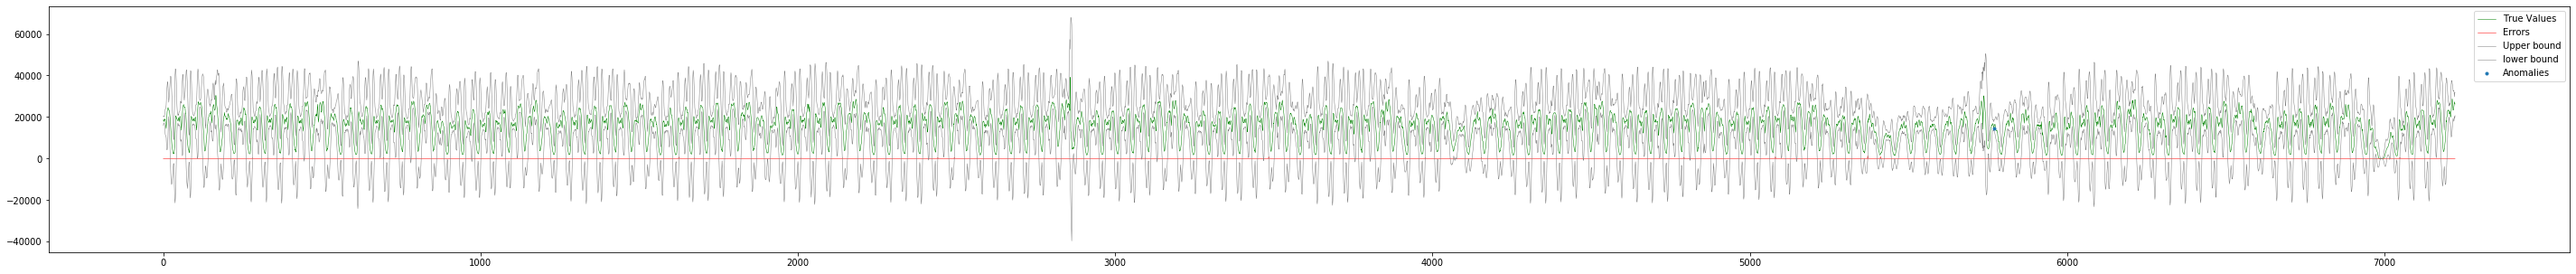

AUC:  0.5377650145914736
Time:  0:00:02.853831


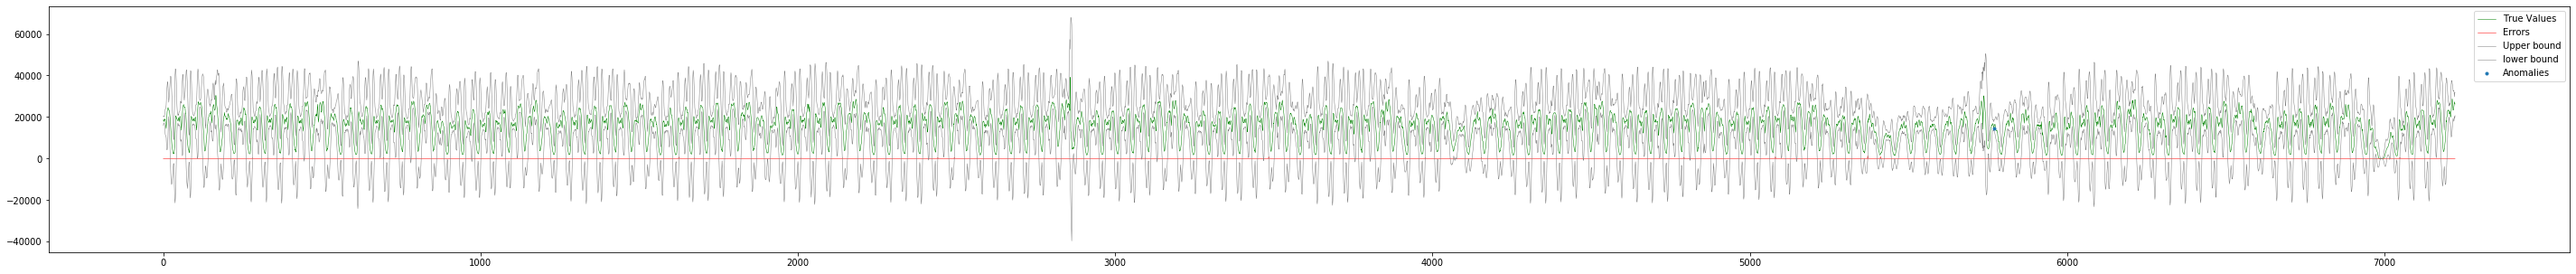

Time:  0:00:02.864557


In [0]:
import sys
import os
import datetime
startTime = datetime.datetime.now()
files = []
import glob


ar_model = PCI( 'drive/My Drive/MT/Experiments/Univariate/NYC_Taxi/nyc_taxi.csv', 0.3, window_width=5)
ar_model.getAndReadAnaomaliesByPCI()

ar_model.get_roc_auc(plot=False,verbose=False)


endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff)    
startTime = datetime.datetime.now()

ar_model.getAndReadAnaomaliesByPCI()
endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff)  

## PCI

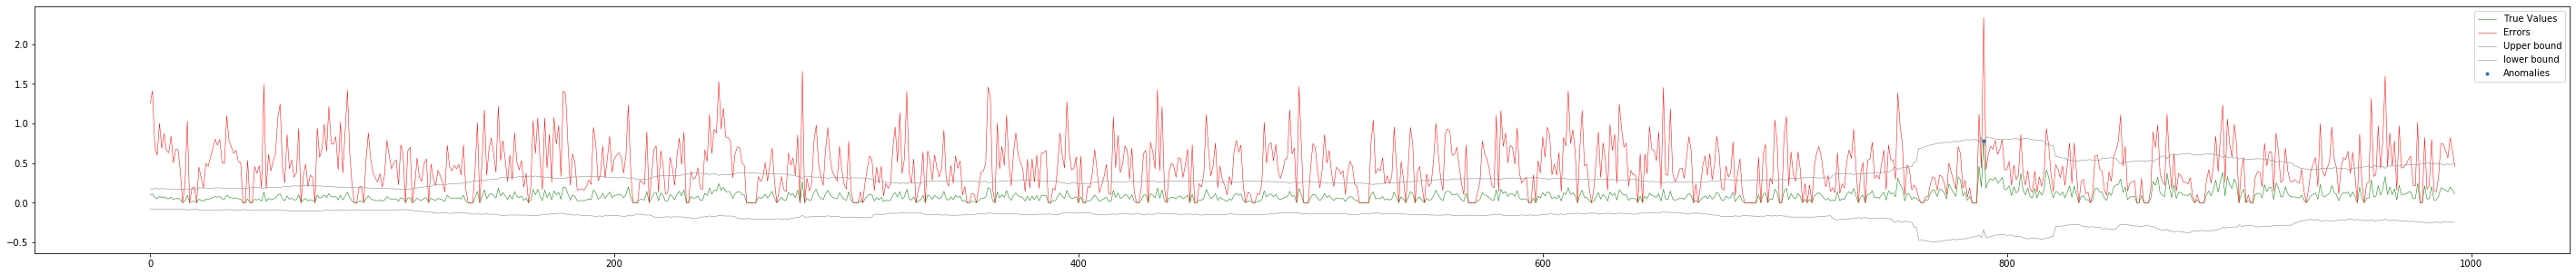

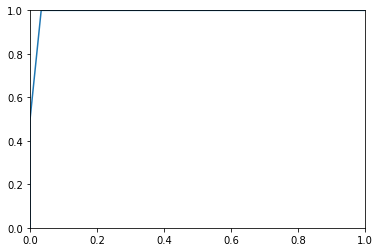

AUC:  0.9896881287726358


0.9896881287726358

In [0]:
import numpy as np
import statistics
import math
import matplotlib.pyplot as plt
import scipy.stats
import ipywidgets as widgets
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from pandas import read_csv
from tqdm import tqdm_notebook, tnrange
from matplotlib import pyplot


class PCI:

    def __init__(self, path, train_rate, window_width=50):
        self.df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'anomaly':'is_anomaly'}, inplace=True)
        series = self.df.iloc[:,0]
        self.window_width = window_width
        # split into train and test sets

        self.X = series.values
        size = int(len(self.X ) * train_rate)

        self.train_size = int(len(series.values) * train_rate)
        self.train, self.test = self.X[0:size], self.X[size:len(self.X)]

    def getWindow_Mean(self, sqlResult, row_index, column_index, window_width):
        '''
        sqlResult: The data from mysql database starting with the timestamp field
        row_index: The record we want to analyze if it contains anomalies
        column_index: the field in the sqlresult we want to analyze for the currenct record
        window_width: the amount of data we bundle to compute mean and std 
        This function gets all the data that are window_width * 0.5 before and after the current data point and 
        then it computes the std and mean of it. Then it looks if they are more than 3*std away from the mean
        '''
        lst_field = []
        lst_timestamp = []
        for counter,x in enumerate(sqlResult):
            lst_field.append(x)
            lst_timestamp.append(counter)

        index_begin = max(0,int(row_index-window_width/2))
        index_end = min(len(lst_field),int(row_index+window_width/2))-1
        sliced_lst_field = lst_field[index_begin:index_end]
        sliced_lst_timestamp = lst_timestamp[index_begin:index_end]
        mean=statistics.mean(sliced_lst_field)
        std = statistics.stdev(sliced_lst_field)
        lst_ad_field = []
        lst_ad_timestamp = []
        lst_ad_timestamp_range = []
        for counter,elem in enumerate(sliced_lst_field):
            if abs(elem - mean) > 3*(std):
                lst_ad_field.append(elem)
                lst_ad_timestamp.append(sliced_lst_timestamp[counter])
                lst_ad_timestamp_range.append((lst_timestamp[index_begin],lst_timestamp[index_end-1]))
        return lst_ad_timestamp,lst_ad_field, set(lst_ad_timestamp_range)

    def getWindowedAnomalies(self, sql_result,show_range=False):
        '''
        sqlResult: The data from mysql database starting with the timestamp field
        window_width: the amount of data we bundle to compute mean and std 
        show_range: If anomlay is detected for a data point, it marks the range of data that has been analyzed gray
        This functions iterates over the whole data in sql_result and detects anomalies that have a value more than 3*std away from mean
        it only analyzed this data for the second field in sql_result. The first field must contain the timestamp
        '''
        glb_lst_ad_timestamp, glb_lst_ad_field, glb_lst_ad_range_begin, glb_lst_ad_range_end = [],[], [],[]
        lst_timestamp = []
        lst_field = []
        sliced_sqlResult = []
        for counter, row in enumerate(sql_result):
            lst_timestamp.append(counter)
            lst_field.append(row)

            lst_ad_timestamp, lst_ad_field, lst_ad_range = self.getWindow_Mean(sql_result,counter,1,self.window_width)
            glb_lst_ad_timestamp += lst_ad_timestamp
            glb_lst_ad_field += lst_ad_field
            if show_range:
                for ad_range in lst_ad_range:
                    glb_lst_ad_range_begin.append(ad_range[0])
                    glb_lst_ad_range_end.append(ad_range[1])

        plt.figure(figsize=(18,5))
        plt.plot(lst_timestamp, lst_field)

        for counter,_ in enumerate(glb_lst_ad_range_begin):
            plt.axvspan(glb_lst_ad_range_begin[counter], glb_lst_ad_range_end[counter], color='gray', alpha=0.1)

        plt.plot(glb_lst_ad_timestamp, glb_lst_ad_field, linestyle="",marker=".")
        plt.show()

    def calculatePCI(self, sql_result,index, k, BothSidedWindow= True):
        '''
        sqlResult: The data from mysql database starting with the timestamp field
        index: The record we want to analyze if it contains anomalies
        k: the k parameter from the paper
        BothSideWindow: if true we look left and right of the datapoint, otherwise just left of the datapoint 
        This function implements completely the algorith proposed in the mentioned paper. Instead of using Students t-Test
        I implemented a similar approach using Z-table of normal distribution
        '''
        lst_values = []
        start = 0
        end = 0
        if BothSidedWindow:
            start =max(0,index-k)
            end = min(len(sql_result), index+k)-1
        else:
            start = max(0,index - 2*k)
            end = min(len(sql_result),index)
        v_i_zaehler = 0
        v_i_nenner = 0
        for counter,i in enumerate(range(start,end )):
            if i == index:
                continue
            lst_values.append(sql_result[i])
            w = 0
            if i<index:
                w = counter+1
            else:
                w = 2*k - counter 
            v_i_zaehler += sql_result[i]*w
            v_i_nenner +=w
        # if we cannot predict, just return the value
        if v_i_zaehler == 0 or len(lst_values)<2: 
            return (sql_result[index]-1,sql_result[index]+1)
        
        v_index = v_i_zaehler/v_i_nenner
        std = statistics.stdev(lst_values)

        t_student=0
        # the higher k the closer z to 0.5 - max = 120
        # 0.5 + ((120-min(k,120))/120)*0.4999999999
        percentile = 0.5 + ((120-min(k,120))/120)*0.4999999999
        z = scipy.stats.norm.ppf(percentile)
        delta = z * std* np.sqrt(1+1/2*k)
        PCI = (v_index - delta,v_index+delta)
        return PCI

    def plotAnomaliesByPCI(self, sql_result, plot = True):
        '''
        sqlResult: The data from mysql database starting with the timestamp field
        Calculate Anomalies by PCI as described in the paper and plot it
        '''
        lst_timestamp = []
        lst_field = []
        lst_PCI_up = []
        lst_PCI_down = []
        lst_ad_timestamp =[]
        lst_ad_value = []
        self.lst_anomalyScores = []
        for counter, row in enumerate(sql_result):
            PCI = self.calculatePCI(sql_result,counter,self.window_width,True)
            lst_timestamp.append(counter)
            lst_field.append(row)
            lst_PCI_up.append(PCI[1])
            lst_PCI_down.append(PCI[0])
            if PCI[0]!=0:
                self.lst_anomalyScores.append(abs(row/PCI[0]))
            else:
                self.lst_anomalyScores.append(min(2,row))

            if row>PCI[1] or row<PCI[0]:
                lst_ad_value.append(row)
                lst_ad_timestamp.append(counter)
        if plot:
            plt.figure(figsize=(50,5))
            plt.plot(lst_timestamp, lst_field, color='green',  linewidth=0.5,label='True Values')
            plt.plot(self.lst_anomalyScores, color = 'red',  linewidth=0.5, label='Errors')
            plt.plot(lst_timestamp, lst_PCI_up, color = 'gray',  linewidth=0.5, label='Upper bound')
            plt.plot(lst_timestamp, lst_PCI_down, color = 'gray',  linewidth=0.5, label='lower bound')
            plt.plot(lst_ad_timestamp, lst_ad_value, linestyle="",marker=".", label='Anomalies')
            pyplot.legend()
            plt.show()    


        self.errors = np.array(self.lst_anomalyScores)


    def getAndReadAnaomaliesByPCI(self, plot = True):
        myresult = self.test
        self.plotAnomaliesByPCI(myresult, plot)
        # self.getWindowedAnomalies(myresult,show_range=True)

    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size ]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan

        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)

pci = PCI('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_1.csv', 0.3, window_width=30)
pci.getAndReadAnaomaliesByPCI()
pci.get_roc_auc(verbose=False)

### Evaluation

In [0]:

import os
import datetime
startTime = datetime.datetime.now()
import glob

dfs = [pd.DataFrame(columns=['filename', 'auc']), pd.DataFrame(columns=['filename', 'auc']),pd.DataFrame(columns=['filename', 'auc']),pd.DataFrame(columns=['filename', 'auc'])]
files = []
import glob
folders = ['A1Benchmark','A2Benchmark','A3Benchmark','A4Benchmark']
for j,folder in enumerate(folders):
    for i,file in enumerate(glob.glob('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/'+ folder + '/*.csv')):
        pci = PCI( file, 0.3, 30)
        pci.getAndReadAnaomaliesByPCI(plot=False)
        print(file,end=' - ')
        dfs[j].loc[i] = [os.path.basename(file),pci.get_roc_auc(plot=False,verbose=False)]


endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff.seconds)
print(dfs[0].describe())
print(dfs[1].describe())
print(dfs[2].describe())
print(dfs[3].describe())                

drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_1.csv - AUC:  0.9896881287726358
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_11.csv - AUC:  0.02694235588972426
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_12.csv - AUC:  0.7874503968253969
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_10.csv - AUC:  0.9697039072039072
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_13.csv - AUC:  0.5429343033509701
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_15.csv - AUC:  0.5783730158730158
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_17.csv - AUC:  0.48230373941206883
drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_14.csv - drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Be